# Preparation

In [1]:
# Install Keras's core and NLP function updates
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 23.4 MB/s eta 0:00:0000:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [28]:
# Import function libraries
import keras_nlp
import sklearn
import keras_core as keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split

# Display the current version of TensorFlow and KerasNLP
print("TensorFlow version: ", tf.__version__)
print("KerasNLP version: ", keras_nlp.__version__)

TensorFlow version:  2.15.0
KerasNLP version:  0.12.1


# Load the tweet dataset

In [3]:
# Load the disaster tweets
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

# Display the memory size of both train and test datasets
print('Training set shape = {}'.format(df_train.shape))
print('Training set memory usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Testing set shape = {}'.format(df_test.shape))
print('Testing set memory usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training set shape = (7613, 5)
Training set memory usage = 0.29 MB
Testing set shape = (3263, 4)
Testing set memory usage = 0.10 MB


In [4]:
# Show first five rows of the train dataset
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Show first five rows of the test dataset
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Surf the tweet dataset

In [7]:
# Explore the dataset
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train length statistics")
print(df_train["length"].describe())

print()

print("Test length statistics")
print(df_test["length"].describe())

Train length statistics
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test length statistics
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


# Data pre-processing

In [8]:
# Pre-process the data
batch_size = 32
num_training_examples = df_train.shape[0]
train_split = 0.8
val_split = 0.2
steps_per_epoch = int(num_training_examples) * train_split // batch_size

epochs = 2
auto = tf.data.experimental.AUTOTUNE

In [9]:
X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_split, random_state=42)

X_test = df_test["text"]

# Transformation phase (using DistilBERT model)

In [10]:
# Load a DistilBERT model from KerasNLP
preset = "distil_bert_base_en_uncased"

# Assign shorter sequence length
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    preset,
    sequence_length=160,
    name="preprocessor_4_tweets"
)

# Assign pre-trained classifier
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    preset,
    preprocessor=preprocessor,
    num_classes=2
)

classifier.summary()

Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'preprocessor.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'task.

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone (DistilBertBackbone)     │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem (SlicingOpLambda)    │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ output_dropout (Dropout)                      │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

# Model training (using DistilBERT fine-tuning)

In [22]:
# 1st step: Compile
classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics=["accuracy"]  
)

# 2nd step: Fit
history = classifier.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val)
)

Epoch 1/2


I0000 00:00:1718095296.626521     130 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718095296.711625     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 [==============================] - ETA: 0s - loss: 0.4914 - accuracy: 0.7818

W0000 00:00:1718095360.946797     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718095364.930253     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/191 [==============================] - 100s 383ms/step - loss: 0.4914 - accuracy: 0.7818 - val_loss: 0.3898 - val_accuracy: 0.8490


W0000 00:00:1718095369.738051     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/2
191/191 [==============================] - 55s 288ms/step - loss: 0.3685 - accuracy: 0.8491 - val_loss: 0.3824 - val_accuracy: 0.8510


# Confusion matrix

In [26]:
# Define confusion matrix function
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Non-disaster", "Disaster"],
        cmap=plt.cm.Blues
    )
    
    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    
    f1_score = tp / (tp + ((fn + fp) / 2))
    
    disp.ax_.set_title("Confusion matrix on" + dataset + "Dataset -- F1 Score: " + str(f1_score.round(2)))

# Data visualization

191/191 [==============================] - 13s 67ms/step


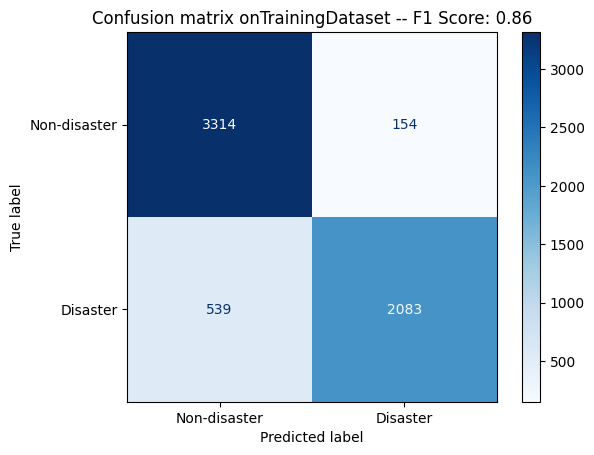

In [29]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 [==============================] - 5s 97ms/step


W0000 00:00:1718095701.166019     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


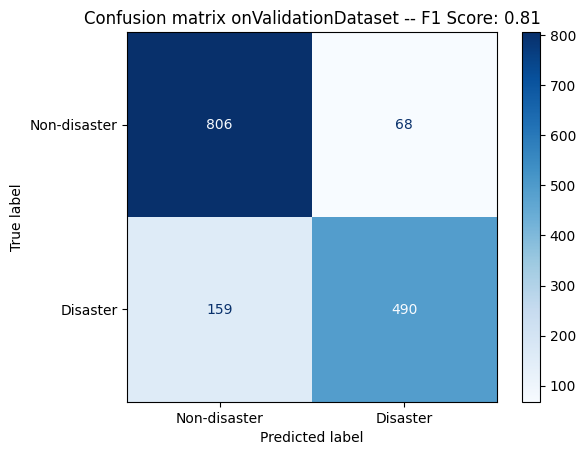

In [30]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

# Generate submission

In [31]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [32]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

sample_submission.describe()

102/102 [==============================] - 9s 85ms/step


W0000 00:00:1718096444.840472     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.352436
std,3146.427221,0.477802
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [34]:
sample_submission.to_csv("submission.csv", index=False)

print("Successfully saved as CSV file")

Successfully saved as CSV file
